Author: Akshay Chougule

Creation Date: 28-Feb-2020

Description: This is a v8.2 of notebook for Human-Protein-Atlas-Competition.

- Attempt to implement F1-loss

In [1]:
import pandas as pd
import time
import os
import copy

In [2]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [3]:
import fastai
from fastai.vision.image import *
from fastai.vision import *
from fastai.metrics import *

In [4]:
data_root = '/home/ubuntu/datasets/human-protein-atlas/'

In [5]:
train_labels = pd.read_csv(os.path.join(data_root,'train.csv'))
train_labels.head(5)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


__Create the databunch__

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
additional_aug=[*zoom_crop(scale=(0.75,1.25), do_rand=False), 
#                     brightness(scale=(0.4, 0.6)), 
#                     contrast(scale=(0.6, 1.4), p=0.75)
                   ]
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms(dihedral_affine(),max_lighting=0.2, max_zoom=1.15, xtra_tfms=additional_aug)

In [8]:
test = ImageList.from_csv(data_root,'sample_submission.csv',folder='test_512by512',suffix='.png')

In [9]:
src = (ImageList.from_csv(data_root,'train.csv',folder='train_512by512',suffix='.png')
        .split_by_rand_pct(0.2)
        .label_from_df(cols='Target',label_delim=' ')
       .add_test(test))

In [10]:
src.train.databunch

<bound method LabelList.databunch of LabelList (24858 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
16;0,7;1;2;0,5,1,18
Path: /home/ubuntu/datasets/human-protein-atlas>

In [11]:
src.valid.databunch

<bound method LabelList.databunch of LabelList (6214 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
25;1,0,14,19;5;0,25
Path: /home/ubuntu/datasets/human-protein-atlas>

In [12]:
src.test.databunch

<bound method LabelList.databunch of LabelList (11702 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: /home/ubuntu/datasets/human-protein-atlas>

^ that looks correct. We have 80% of the images in train and 20% in validation databunch as specified. Alos the test data count match.

In [13]:
data = (src.transform(tfms, size=512)
        .databunch(bs = 16).normalize(imagenet_stats))

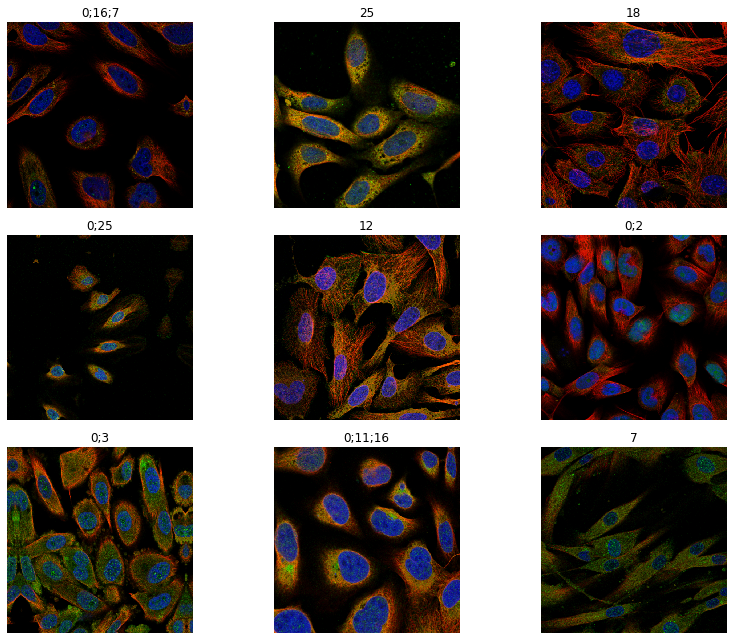

In [14]:
data.show_batch(rows=3, figsize=(12,9))

In [17]:
# class MultiLabelFbeta2(callbacks):
#     "Computes the fbeta score for multilabel classification"
#     # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
#     _order = -20 
#     def __init__(self, beta=2, eps=1e-15, thresh=0.3, sigmoid=True, average="micro"):
#         super(MultiLabelFbeta2, self).__init__()
#         self.eps,self.thresh,self.sigmoid,self.average,self.beta = eps,thresh,sigmoid,average,beta
#         self.tp,self.total_pred,self.total_targ = 0,0,0
    
#     #def on_batch_end(self, last_output, last_target, **kwargs):
#     def forward(self, input, target):
#         pred, targ = ((input.sigmoid() if self.sigmoid else input) > self.thresh).byte(), target.byte()
#         m = pred*targ
#         self.tp += m.sum(0).float()
#         self.total_pred += pred.sum(0).float()
#         self.total_targ += targ.sum(0).float()
#         # add epsilon
#         self.total_pred += self.eps
#         self.total_targ += self.eps
#         #  derive precision and recall
#         precision, recall = self.tp.sum() / self.total_pred.sum(), self.tp.sum() / self.total_targ.sum()
#         # Using the beta2 value let's derive fbeta score
#         beta2 = self.beta**2
#         fbeta_score = (1 + beta2)*(precision*recall)/((beta2*precision + recall) + self.eps)
#         return 1 - fbeta_score

In [18]:
# Steve's version
class F1:
    __name__ = 'F1_macro'
    def __init__(self,n=28):
        self.n = n     
        self.TP = torch.zeros(1, self.n).cuda()
        self.FP = torch.zeros(1, self.n).cuda()
        self.FN = torch.zeros(1, self.n).cuda()

    def __call__(self,preds,targs,th=0.0):
        preds = (preds > th).int()
        targs = targs.int()       
        self.TP += (preds*targs).float().sum(dim=0)
        self.FP += (preds > targs).float().sum(dim=0)
        self.FN += (preds < targs).float().sum(dim=0)
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6)).mean()
        return score

    def reset(self):
        #macro F1 score
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6))
        print('F1 macro:',score.mean(),flush=True)
        self.TP = torch.zeros(1, self.n).cuda()
        self.FP = torch.zeros(1, self.n).cuda()
        self.FN = torch.zeros(1, self.n).cuda()

class F1_callback(Callback):
    def __init__(self, n=28):
        self.f1 = F1(n)

    def on_epoch_end(self, metrics):
        self.f1.reset()

In [ ]:
def focal_loss(y_pred,y_true,alpha=0.25,gamma=2,):
    
    #alpha=0.25,gamma=2
    if isinstance(alpha,(list,tuple)):
        fore_alpha = alpha[0] # postive sample ratio in the entire dataset
        back_alpha = alpha[1] #(1-alpha) # negative ratio in the entire dataset
    elif isinstance(alpha ,(int,float)):
        fore_alpha = alpha
        back_alpha = (1-alpha)
        
    n_positives = (y_true!=0).sum() # all postive anchors for 28 class
    
    #print(y_true.size())
    #print(type(y_true))
    #y_true = y_true.long()
    #print(y_true)
    #y_true = torch.eye(y_pred.shape[-1])[y_true].cuda() # one hot vector for all prediction
    #print(y_true)
    y_pred = F.softmax(y_pred,dim=1) # apply softmax
    
    #print(y_pred.size())
    
    y_true = y_true.to('cuda')
    
    #yt = y_true
    #yp = y_pred
    
    
    # in the dataset background classes is taken in the front so 1 background class + 27 classes = 28 classes
    back_pred = y_pred[:,0:1] # 1st column background
    fore_pred = y_pred[:,1:]  # 20 columns foreground
    back_true = y_true[:,0:1]  # 1st column background
    fore_true = y_true[:,1:] # 20 columns foreground
    
    #print('Size of back_pred'+  str(back_pred.size()) + '  Size of fore_pred' + str(fore_pred.size()))
    #print('Size of back_true'+  str(back_true.size()) + '  Size of fore_true' + str(fore_true.size()))
    
    #print(back_true.size(),back_alpha,fore_true.size(),fore_alpha)
    alpha_factor = torch.cat([ back_true *back_alpha ,  fore_true * fore_alpha],dim=1)  ## alpha factor 
         
    #print(back_true.size(),back_pred.size(),fore_true.size(),fore_pred.size())
    #print(back_true.size(),back_pred.size(),fore_true.size(),fore_pred.size())
    focal_weight = torch.cat([ back_true * back_pred , fore_true * (1-fore_pred) ] ,dim=1) #because background is also a class so (1-back_true) will lead to false output
    fc1 = back_true * back_pred 
    #print(fc1.size())
    #print('Size of fore_true'+  str(fore_true.size()) + '  Size of fore_pred' + str(fore_pred.size()))
    fc2 = fore_true * (fore_pred)
    #print(fc2.size())
    
    cross_entropy = -1 *  torch.log(y_pred) # normal cross entropy
    
    focal_weight = focal_weight.to('cuda')
    #gamma = gamma.to('cuda')
    cross_entropy = cross_entropy.to('cuda')
    alpha_factor = alpha_factor.to('cuda')
    
    loss =  alpha_factor * (focal_weight ** gamma) * cross_entropy # focal loss with modulating factor
    
    # normalize the loss with positive anchors
    return loss.sum()/n_positives 

In [120]:
# Does not work
def f1_loss(y_pred,y_true,n=28,th=0.0):
    TP = torch.zeros(1, n).cuda()
    FP = torch.zeros(1, n).cuda()
    FN = torch.zeros(1, n).cuda()
    
    TP.requires_grad = True
    FP.requires_grad = True
    FN.requires_grad = True
    
    preds = (y_pred > th).int()
    targs = y_true.int()    
    TP += (preds*targs).float().sum(dim=0).cuda()
    FP += (preds > targs).float().sum(dim=0).cuda()
    FN += (preds < targs).float().sum(dim=0).cuda()
    score = (2.0*TP/(2.0*TP + FP + FN + 1e-6)).mean()
    loss = 1-score
    return loss

In [40]:
# v2
def f1_loss(y_pred,y_true,n=28,th=0.0):
    TP = torch.zeros(1, n).cuda()
    FP = torch.zeros(1, n).cuda()
    FN = torch.zeros(1, n).cuda()
   
    #preds = (y_pred > th).int()
    preds = y_pred.round()
    targs = y_true
    TP += (preds*targs).float().sum(dim=0).cuda()
    FP += (preds > targs).float().sum(dim=0).cuda()
    FN += (preds < targs).float().sum(dim=0).cuda()
    score = (2.0*TP/(2.0*TP + FP + FN + 1e-6)).mean()
    loss = 1 - score.clamp(min=0)
    return loss

In [121]:
arch = models.resnet18
# this is used generally for single label
f1_score = partial(fbeta, thresh=0.2, beta=1)
# This is a fastai v1 factory method
f1_multi = MultiLabelFbeta(beta=2, average="macro")
# This is Steve's method
#f1_callback = F1_callback(n=data.c)

In [41]:
setattr(src, 'device', 'cuda') 

In [42]:
learn = cnn_learner(data, arch, metrics=f1_mulit)

In [43]:
# f1_loss = MultiLabelFbeta2(beta=2)
learn.loss_func = f1_loss

In [44]:
learn.data.batch_size

16

In [45]:
# learn.lr_find does not work
learn.lr_find()

epoch,train_loss,valid_loss,multi_label_fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [46]:
!cat /usr/local/cuda/version.txt

CUDA Version 10.2.89


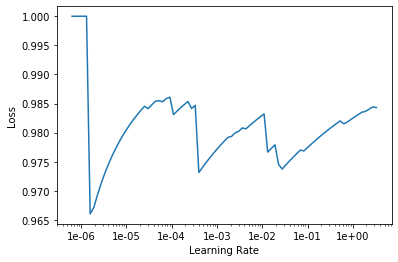

In [47]:
learn.recorder.plot()

In [48]:
lr = 0.01/3

In [49]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.995769,0.989314,0.173676,02:42
1,0.993645,0.993633,0.177115,02:44
2,0.993448,0.995169,0.178938,02:43
3,0.995172,0.992301,0.178808,02:45
4,0.996248,0.995020,0.179709,02:44


In [29]:
# w/o f1 loss for reference
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta,multi_label_fbeta,F1_macro,time
0,0.128971,0.118169,0.569831,0.276798,0.185837,02:42
1,0.130476,0.118105,0.571362,0.287509,0.194214,02:44
2,0.125714,0.113886,0.589455,0.296842,0.202170,02:45
3,0.119087,0.112108,0.593900,0.293855,0.209411,02:46
4,0.120050,0.111581,0.599601,0.302272,0.215380,02:46


In [85]:
# v3
def f1_loss(y_pred,y_true,n=28,th=0.0):
    TP = torch.zeros(1, n).cuda()
    FP = torch.zeros(1, n).cuda()
    FN = torch.zeros(1, n).cuda()
    
    TP.requires_grad = True
    FP.requires_grad = True
    FN.requires_grad = True
    
    # Keras has K.epsilon(), so in ytorch we could do:
    eps=1e-9
    
    precision = TP / (TP + FP + eps)
    recall    = TP / (TP + FN + eps)

    f1 = 2*precision*recall / (precision+recall+eps)
    #f1[torch.isnan(f1)] = 0
    
    score = f1.mean()
    loss = 1 - score #.clamp(min=0)
    return loss

In [86]:
learn = cnn_learner(data, arch, metrics=f1_mulit)
learn.loss_func = f1_loss

In [87]:
learn.lr_find()

epoch,train_loss,valid_loss,multi_label_fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


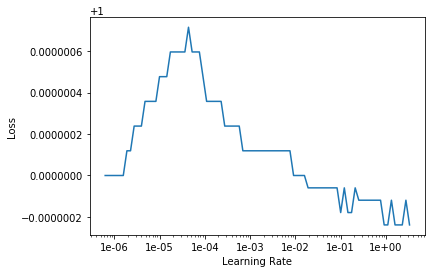

In [88]:
learn.recorder.plot()

In [89]:
lr = 0.1
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.999999,1.000000,0.183754,02:23
1,0.999999,1.000000,0.183964,02:24
2,0.999999,1.000000,0.183964,02:23
3,0.999999,1.000000,0.183964,02:24
4,0.999999,1.000000,0.183964,02:24


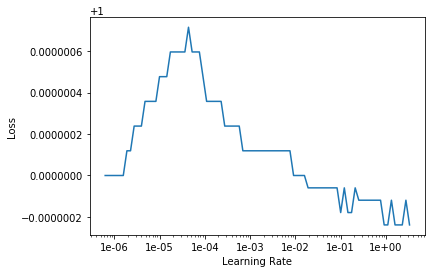

In [78]:
learn.recorder.plot()

In [73]:
lr = 0.01
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.999999,1.000000,0.175608,02:23
1,0.999999,1.000000,0.180162,02:23
2,0.999999,1.000000,0.182574,02:24
3,0.999999,1.000000,0.183474,02:25
4,0.999999,1.000000,0.183297,02:24


In [74]:
# Higher learning rate
lr = 0.01
learn.fit_one_cycle(5, lr*3)

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.999999,1.000000,0.183946,02:23
1,0.999999,1.000000,0.183964,02:24
2,0.999999,1.000000,0.183964,02:23
3,0.999999,1.000000,0.183964,02:25
4,0.999999,1.000000,0.183964,02:24


In [116]:
# v4: from kaggle kernel
def f1_loss(target, output, epsilon=1e-7):
    #y_pred = nn.Sigmoid()(output).double()
    y_pred = output.double()
    y_true = target.double()

    TP = (y_pred * y_true).sum(1)
    prec = TP / (y_pred.sum(1))
    rec = TP / (y_true.sum(1))
    res = 2 * prec * rec / (prec + rec)

    f1 = res
    print(f"The f1 value: {f1}")
    f1 = f1.clamp(min=0)
    F1 = f1.mean()
    print(f"The F1 value: {F1}")
    return 1 - F1

In [119]:
learn = cnn_learner(data, arch, metrics=f1_multi)
learn.loss_func = f1_loss

In [115]:
learn.lr_find()

epoch,train_loss,valid_loss,multi_label_fbeta,time


The f1 value: tensor([-0.9109,  0.6054,  1.2200,  0.7264, -0.4640,  0.2024, -9.9234, -0.0540,
         0.0375,  3.3430, -2.2586,  0.2708, -0.5424,  0.0577,  0.0409,  0.5309],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
The F1 value: 0.4396867261873396
The f1 value: tensor([  1.0392,  -0.0195,   0.2790,   0.5253,  -1.5126,  -1.4333,  -0.4556,
         -0.2294,   0.5216,  -0.0941,  -0.1415,   0.2724,  -2.9873, -16.3182,
         -0.3355,  -0.3840], device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)
The F1 value: 0.1648514210567024
The f1 value: tensor([ -0.9266,  -0.1740,   0.8201,   3.6778,   0.5475,  -0.6158,  -0.1802,
          0.2536,   0.3016,  -0.0487,   0.4346, -23.3510,  -0.0823,  -0.0249,
          0.3746,   0.5655], device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)
The F1 value: 0.43596241665679586
The f1 value: tensor([  2.8585,  -0.4958,  -2.2760,   0.2422,   0.1292,   0.3291,   0.4148,
          1.4359,   2.0375, 

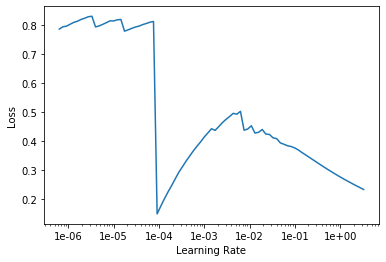

In [93]:
learn.recorder.plot()

In [65]:
lr = 0.01

In [66]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.073980,0.024569,0.184011,02:40
1,0.018082,0.020694,0.112871,02:43
2,-0.022114,-0.031136,0.183505,02:41
3,-0.026989,-0.030377,0.185912,02:42
4,-0.165563,-0.075873,0.182751,02:42


In [99]:
f1_score = partial(fbeta, thresh=0.2, beta=1)
learn = cnn_learner(data, arch, metrics=f1_score)
learn.loss_func = f1_loss

epoch,train_loss,valid_loss,fbeta,time


The f1 value: tensor([-0.1349,  0.0754,  0.3362,  0.1752, -0.2502,  0.3418, -0.1690, -1.6571,
        -0.0575, -0.5135,  0.0767,  0.0078, -0.9407, -0.1412,  0.1563,  0.1986],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
The F1 value: 0.08549516126039924
The f1 value: tensor([-0.5227, -0.4040,  0.2483, -0.0276,  0.3573,  0.4338, -0.6795, -0.1372,
        -1.9086,  0.0680, -1.5100,  0.1845, -0.3484,  0.2781, -0.1513,  0.1006],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
The F1 value: 0.1044036905656683
The f1 value: tensor([ 0.0442, -0.9593,  0.0354,  0.4192,  0.2638, -0.9203, -2.4045,  0.1146,
         0.3327, -0.9793,  0.3300,  0.1891, -1.5101, -0.2736,  0.3913,  0.1792],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
The F1 value: 0.1437172045113272
The f1 value: tensor([ 0.1909,  0.2463,  0.1081, -0.5127, -5.0014, -0.0555,  0.1785, -0.3010,
         0.3805,  0.3919, -0.8706,  0.2178, -0.3493, -0.2403, -1.3073, -0.

The f1 value: tensor([ 0.1428, -0.1821,  0.1498,  0.0914,  0.2789,  0.3984, -1.0314,  0.1113,
         0.2210, -0.2031, -0.1333, -0.4883, -0.0421, -0.7450, -0.8749, -0.0637],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
The F1 value: 0.08709562652226253
The f1 value: tensor([-0.4246, -0.1964, -0.4036, -1.2829,  0.2493,  0.1437,  0.0146,  0.3733,
        -0.0749, -0.0283, -0.1249, -0.2325, -0.1299, -0.4850,  0.2393,  0.0897],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
The F1 value: 0.06936924510414022
The f1 value: tensor([ 5.1239e-01,  4.6534e-01,  6.6742e+01,  2.0005e-01, -2.3527e-01,
        -1.1998e-01,  3.1932e-01, -3.0215e-01, -8.4310e-01, -2.2090e-01,
        -3.4855e-02,  4.4359e-01, -1.0422e+00,  2.1152e-01, -2.8902e-01,
         1.9223e-01], device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)
The F1 value: 4.3179224949098955
The f1 value: tensor([ 0.4211,  0.4186,  0.4633, -0.3024, -0.1567, -1.5874, -0.1398, -0

The f1 value: tensor([ 0.1651, -0.5354, -0.3724,  0.1551,  0.2136,  0.2446, -0.2615,  0.0100,
         0.3825, -0.5083, -1.4186,  0.2080,  0.0087,  0.3407,  0.0735,  0.2352],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
The F1 value: 0.12730375158893176
The f1 value: tensor([-0.6070,  0.3795,  0.1208,  0.3472, -0.0723,  0.1158,  0.2873, -0.0101,
        -1.0908,  0.2655,  0.3530,  0.0204,  0.2549, -9.3767, -0.3048,  0.2168],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
The F1 value: 0.1475646368170327
The f1 value: tensor([-0.1165,  0.1529, -5.7627,  0.2609,  0.1678, -2.0029,  0.2191, -0.3835,
        -0.7474,  0.3432,  0.3688, -0.2378,  0.5596,  0.1843,  3.4495, -0.2058],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
The F1 value: 0.3566238135987212
The f1 value: tensor([-0.7498, -3.1796,  0.2010, -0.0549,  0.2746,  0.5349, -0.4324,  0.5495,
         0.2088,  0.1364, -2.6105,  0.2725,  0.1375,  0.4624,  0.2746,  0.

The f1 value: tensor([1.0225, 1.0262, 1.0260, 1.0066, 1.0086, 1.0043, 1.0591, 1.0230, 1.0405,
        1.0102, 1.0229, 1.0112, 1.0252, 1.0077, 1.0039, 1.0114],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
The F1 value: 1.0193319481761962
The f1 value: tensor([1.0114, 1.0057, 1.0099, 1.0093, 1.0269, 1.0414, 1.0110, 1.0068, 1.0087,
        1.0280, 1.0104, 1.0109, 1.0108, 1.0066, 1.0104, 1.0262],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
The F1 value: 1.0146474591299834
The f1 value: tensor([1.0089, 1.0282, 1.0245, 1.0100, 1.0111, 1.0113, 1.0123, 1.0420, 1.0422,
        1.0298, 1.0442, 1.0108, 1.0114, 1.0098, 1.0127, 1.0305],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
The F1 value: 1.021236148298228
The f1 value: tensor([1.0288, 1.0457, 1.0136, 1.0108, 1.0142, 1.0121, 1.0135, 1.0097, 1.0242,
        1.0136, 1.0469, 1.0119, 1.0110, 1.0124, 1.0135, 1.0293],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBa

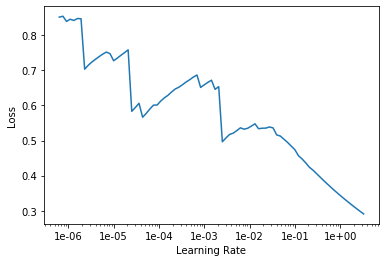

In [100]:
learn.lr_find()
learn.recorder.plot()

In [97]:
lr = 0.1 
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,fbeta,time
0,-0.025671,-0.023691,0.005675,02:40


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/envs/fast

KeyboardInterrupt: 

In [30]:
learn.save('nb-v8-resnet18-stage1-F1-macro')

In [31]:
learn.unfreeze()

epoch,train_loss,valid_loss,fbeta,multi_label_fbeta,F1_macro,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


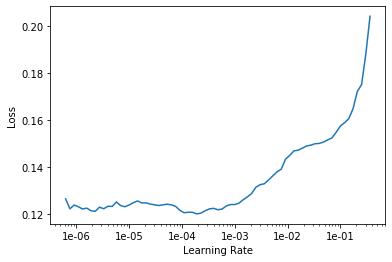

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(10, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,fbeta,multi_label_fbeta,F1_macro,time
0,0.117585,0.110763,0.603015,0.324493,0.221907,03:43
1,0.114313,0.108238,0.618435,0.328324,0.228760,03:45
2,0.111228,0.109141,0.613101,0.325006,0.235269,03:43
3,0.103205,0.103762,0.629926,0.346878,0.242107,03:43
4,0.108051,0.101870,0.638252,0.380854,0.250829,03:44
5,0.102855,0.095590,0.663238,0.420029,0.261699,03:44
6,0.096967,0.093845,0.675046,0.414699,0.271722,03:44
7,0.097548,0.091056,0.676577,0.448103,0.280591,03:46
8,0.086723,0.089775,0.684206,0.453241,0.289981,03:47
9,0.090098,0.089994,0.683560,0.449236,0.298446,03:46


In [34]:
learn.save('nb-v8-resnet18-stage2-F1-macro')

epoch,train_loss,valid_loss,fbeta,multi_label_fbeta,F1_macro,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


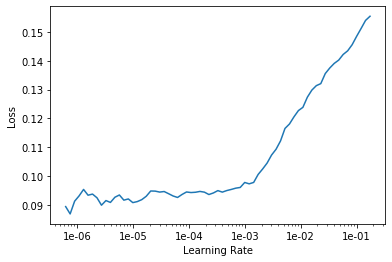

In [35]:
learn.freeze_to(-4)
learn.lr_find()
learn.recorder.plot()

In [36]:
lr

0.0033333333333333335

In [37]:
learn.fit_one_cycle(10, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,fbeta,multi_label_fbeta,F1_macro,time
0,0.089268,0.092080,0.676157,0.449341,0.306083,03:41
1,0.097157,0.094757,0.673197,0.447058,0.312568,03:44
2,0.097576,0.097548,0.663901,0.405894,0.317423,03:43
3,0.095458,0.093391,0.674120,0.437286,0.321196,03:43
4,0.093266,0.091112,0.687358,0.459001,0.325875,03:44
5,0.087839,0.090544,0.682809,0.466629,0.330864,03:44
6,0.085930,0.088821,0.691227,0.474537,0.335828,03:45
7,0.083311,0.087256,0.698929,0.490423,0.341458,03:45
8,0.077045,0.089132,0.692240,0.492406,0.347092,03:46
9,0.079712,0.088837,0.698544,0.486020,0.352153,03:47


In [38]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,fbeta,multi_label_fbeta,F1_macro,time
0,0.081847,0.092110,0.684288,0.466416,0.356581,03:42
1,0.087410,0.094305,0.671297,0.463748,0.359839,03:46
2,0.083727,0.091486,0.684166,0.494132,0.363000,03:46
3,0.076699,0.086732,0.700221,0.512432,0.367195,03:45
4,0.073691,0.087235,0.704881,0.505054,0.371694,03:43


epoch,train_loss,valid_loss,fbeta,multi_label_fbeta,F1_macro,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


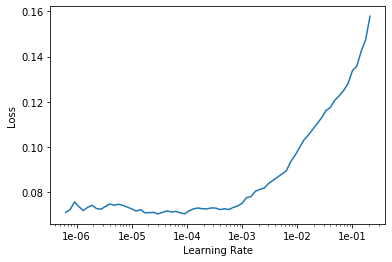

In [39]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot()

In [40]:
lr/5

0.0006666666666666668

In [41]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,fbeta,multi_label_fbeta,F1_macro,time
0,0.074491,0.091289,0.694446,0.494579,0.375630,02:59
1,0.084789,0.089968,0.698145,0.483641,0.378500,03:02
2,0.080288,0.089485,0.697626,0.521997,0.381433,03:01
3,0.067877,0.088847,0.689932,0.532163,0.385344,03:01
4,0.066142,0.089180,0.699039,0.526387,0.389562,03:02


In [44]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,fbeta,multi_label_fbeta,F1_macro,time
0,0.070592,0.093304,0.685192,0.512410,0.393050,02:59
1,0.077910,0.093172,0.683369,0.493253,0.395487,03:02
2,0.074388,0.090704,0.696433,0.508778,0.398098,03:04
3,0.065973,0.089419,0.698889,0.529059,0.401033,03:04
4,0.064058,0.091424,0.695690,0.524750,0.403815,03:04


In [45]:
learn.save('nb-v8-resnet18-stage3-F1-macro')

In [46]:
learn.fit_one_cycle(7, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,fbeta,multi_label_fbeta,F1_macro,time
0,0.066257,0.094617,0.692610,0.514833,0.406365,03:01
1,0.075115,0.093555,0.687832,0.545451,0.408538,03:03
2,0.075163,0.095855,0.679197,0.520068,0.410766,03:04
3,0.071933,0.093678,0.686516,0.528219,0.412932,03:04
4,0.061931,0.091112,0.702772,0.544855,0.415297,03:04
5,0.056634,0.092581,0.703665,0.530487,0.418119,03:05
6,0.054511,0.092850,0.701012,0.546868,0.420631,03:05


### Testing the data

__Making the predictions__

In [47]:
preds, _ = learn.get_preds(DatasetType.Test)

fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512/','')
sample_submission = pd.read_csv(data_root+'sample_submission.csv')

In [48]:
learn.data.test_ds.items

array(['/home/ubuntu/datasets/human-protein-atlas/test_512by512/00008af0-bad0-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0000a892-bacf-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0008baca-bad7-11e8-b2b9-ac1f6b6435d0.png', ...,
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/ffdfc590-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/ffecb8a4-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/fff03816-bad5-11e8-b2b9-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/fffe6f9c-bacd-11e8-b2b8-ac1f6b6435d0.png'],
      dtype='<U96')

Let's try playing around with the threshold

In [49]:
thresholds = [0.2,0.18,0.16,0.14,0.12,0.1]

for thresh in thresholds:
    labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
    fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512/','')
    df = pd.DataFrame({'Id':fnames, 'Predicted':labelled_preds}, columns=['Id', 'Predicted'])
    df2 = pd.merge(sample_submission['Id'], df, on='Id', how='left')
    df2.to_csv('protein_classification_nb-V8_stage2_thresh_'+str(thresh)+'.csv', header=True, index=False)

In [50]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V8_stage2_thresh_0.2.csv -m "Model v8 with resnet18 stage-2 and thrsd 0.2"

100%|█████████████████████████████████████████| 481k/481k [00:00<00:00, 757kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [51]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V8_stage2_thresh_0.18.csv -m "Model v8 with resnet18 stage-2 and thrsd 0.18"

100%|█████████████████████████████████████████| 483k/483k [00:00<00:00, 852kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [52]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V8_stage2_thresh_0.16.csv -m "Model v8 with resnet18 stage-2 and thrsd 0.16"

100%|█████████████████████████████████████████| 486k/486k [00:00<00:00, 760kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [53]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V8_stage2_thresh_0.14.csv -m "Model v8 with resnet18 stage-2 and thrsd  0.14"

100%|█████████████████████████████████████████| 490k/490k [00:00<00:00, 808kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [54]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V8_stage2_thresh_0.12.csv -m "Model v8 with resnet18 stage-2 and thrsd 0.12"

100%|█████████████████████████████████████████| 494k/494k [00:00<00:00, 907kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [55]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V8_stage2_thresh_0.1.csv -m "Model v8 with resnet18 stage-2 and thrsd  0.1"

100%|████████████████████████████████████████| 499k/499k [00:00<00:00, 1.01MB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [56]:
!kaggle competitions submissions -c human-protein-atlas-image-classification > results.txt
!cat results.txt

fileName                                               date                 description                                       status    publicScore  privateScore  
-----------------------------------------------------  -------------------  ------------------------------------------------  --------  -----------  ------------  
protein_classification_nb-V8_stage2_thresh_0.1.csv     2020-02-28 23:12:33  Model v8 with resnet18 stage-2 and thrsd  0.1     complete  0.38773      0.36211       
protein_classification_nb-V8_stage2_thresh_0.12.csv    2020-02-28 23:12:29  Model v8 with resnet18 stage-2 and thrsd 0.12     complete  0.39221      0.36033       
protein_classification_nb-V8_stage2_thresh_0.14.csv    2020-02-28 23:12:27  Model v8 with resnet18 stage-2 and thrsd  0.14    complete  0.39418      0.36509       
protein_classification_nb-V8_stage2_thresh_0.16.csv    2020-02-28 23:12:25  Model v8 with resnet18 stage-2 and thrsd 0.16     complete  0.39351      0.36815       
protein_classifi

In [57]:
learn.fit_one_cycle(7, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,fbeta,multi_label_fbeta,F1_macro,time
0,0.057570,0.094468,0.694055,0.519253,0.422891,02:59
1,0.067802,0.099484,0.676167,0.480636,0.424694,03:03
2,0.068862,0.098815,0.669727,0.511154,0.426177,03:04
3,0.065339,0.095539,0.692123,0.523541,0.427894,03:04
4,0.061199,0.096134,0.691371,0.532684,0.429786,03:05
5,0.051955,0.096985,0.699212,0.539747,0.431647,03:05
6,0.048892,0.097434,0.698283,0.535760,0.433454,03:04
